In [30]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# set paths, create objects

In [31]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171121_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171204_No Obstacles_s.mat'

cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

cca_object = CCAProcessor(cp1, cp2)

this is filipe data i belive
this is filipe data i belive
should be good to align
(6286, 25)
(6286, 5)
(6286, 31)
(6286, 5)


# Getting PCA dimensions

In [32]:

temp, nada, nada = cca_object.apply_PCA()
lowest_num_dimensions = temp
#lowest_num_dimensions = 8
print(lowest_num_dimensions)


22


# storing raw (unaligned, unprocessed) data as test sets

In [33]:
test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions)))
test_y = np.squeeze(np.array(cp2.data['angles']))

test_x_format, test_y_format = format_data(test_x, test_y)

# choosing subsampling list

In [34]:
subsample_list = [.05, .2, .5, 1.0]

# getting day0 decoder

In [35]:
day0_decoder_temp, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(lowest_num_dimensions))
day0_decoder=[]
for i in range(len(subsample_list)):
    day0_decoder.append(day0_decoder_temp)
    
print(np.average(nada, 1))

[ 0.40286863  0.43782177 -0.06775522  0.57289214 -0.09387403]


# getting JUST-PCA decoder

In [36]:
pca_decoder = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    pca_decoder.append(temp_h)

# getting CCA scores

In [52]:
cca_decoder_scores = []

for i in range(len(subsample_list)):
    sub_x1, sub_y1, sub_x2, sub_y2 = cca_object.subsample(percent = subsample_list[i])
    nada, pca_sub_x1, pca_sub_x2 = cca_object.apply_PCA(cp1_x = sub_x1, cp2_x = sub_x2, preset_num_components=lowest_num_dimensions)
    
    temp_cca_transformer, cca_sub_x = cca_object.apply_CCA(cp1_x = pca_sub_x1, cp2_x = pca_sub_x2, preset_num_components = lowest_num_dimensions)
    temp_x = temp_cca_transformer.transform(test_x)
    temp_x = temp_cca_transformer.inverse_transform(test_x)
    temp_x_format, nada = format_data(temp_x, test_y)
    
    predic = test_wiener_filter(temp_x_format, day0_decoder[0])
    
    #print(predic.shape)
    #print(sub_y2_format.shape)
    
    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))


# getting regression decoder

In [53]:
r_decoder = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)

    b = regression_fit(b0=day0_decoder[0], x=np.squeeze(sub_x_pca), y=np.squeeze(sub_y))
    r_decoder.append(b)

# getting VAF scores for each decoder

In [54]:
fixed_decoder_scores=[]
pca_decoder_scores=[]
r_decoder_scores=[]

for i in range(len(subsample_list)):
    temp_y = test_wiener_filter(test_x_format, day0_decoder[i])
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, pca_decoder[i])
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, r_decoder[i])
    r_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

In [55]:
print(fixed_decoder_scores)
print(pca_decoder_scores)
print(cca_decoder_scores)
print(r_decoder_scores)

[-0.6814006966352955, -0.6814006966352955, -0.6814006966352955, -0.6814006966352955]
[-0.776224094279852, 0.21401966118240978, 0.18573141995032627, 0.6425242140550411]
[-0.9599730917567426, -1.6200664193165184, -0.46336049827066983, -1.1680059622089338]
[-1.0798420578183903, 0.123243593829645, 0.17464208545916504, 0.6436601913885291]


# storing aligned/processed data

In [125]:

proc_vaf_scores = []
proc_y_list = []

temp = np.average(cca_dict[var_names[1]].data['cp1']['proc_vaf'], 1)
proc_vaf_scores.append(temp)

temp = cca_dict[var_names[1]].data['cp1']['proc_y']
proc_y_list.append(temp)

for i in range(1, len(var_names)):
    temp = np.average(cca_dict[var_names[i]].data['cp2']['proc_vaf'],1)
    proc_vaf_scores.append(temp)
    
    temp = cca_dict[var_names[i]].data['cp2']['proc_y']
    proc_y_list.append(temp)
        
    temp = cca_dict[var_names[1]].data['cp1']['proc_y'].shape[0]
    if proc_y_list[0].shape[0] > temp:
        proc_y_list[0] = temp
#proc_vaf_scores.append(cca_dict[var_names[0]].cp1.vaf

NameError: name 'cca_dict' is not defined

# applying PCA to processed data

In [189]:
pca_x_list = []

for i in range(1, len(var_names)):
    nada, nada, temp_x = cca_dict[var_names[i]].PCA_to_same_dimensions(preset_num_components = lowest_num_dimensions)
    pca_x_list.append(temp_x)
    
nada, temp_x, nada = cca_dict[var_names[1]].PCA_to_same_dimensions(preset_num_components = lowest_num_dimensions)
pca_x_list.insert(0, temp_x)

# storing PCA vaf scores and decoder

In [190]:
pca_h_matrices = []
pca_vaf_list = []
proc_y_list_format = []
pca_x_list_format = []
for i in range(len(pca_x_list)):
    print(pca_x_list[i].shape, proc_y_list[i].shape)
    temp_x, temp_y = format_data(pca_x_list[i], proc_y_list[i])
    pca_x_list_format.append(temp_x)
    proc_y_list_format.append(temp_y)
    
    temp_h, temp_vaf, nada, nada = decode_kfolds(temp_x, temp_y)
    pca_h_matrices.append(temp_h)
    pca_vaf_list.append(np.round((np.average(temp_vaf,1)), 2))     

(6286, 16) (6286, 5)
(6286, 16) (6286, 5)
(4690, 16) (4690, 5)
(6790, 16) (6790, 5)


In [112]:
x = pca_x_list_format[2]
y = proc_y_list_format[2]
b0= pca_h_matrices[0]

In [113]:
predic = test_wiener_filter(x, b0)
print(vaf(y[:,1], predic[:,1]))

0.08971335522704182


In [114]:
y_star = y - predic
x_plus_bias = np.c_[np.ones((np.size(x, 0), 1)), x]

In [115]:
clf = Ridge(alpha=1.0)
clf.fit(x_plus_bias, y_star)

Ridge()

In [116]:
Wpost = clf.coef_.T
print(Wpost.shape)

(161, 5)


In [117]:
b = Wpost + b0

In [118]:
test = test_wiener_filter(x, b)

0.5709934905778465


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
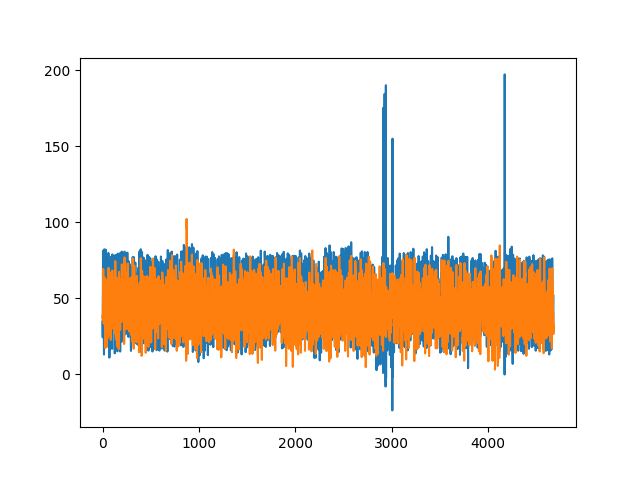

In [119]:
fig, ax = plt.subplots()
ax.plot(y[:,1])
ax.plot(test[:,1])


print(vaf(y[:,1], test[:,1]))

In [165]:
array = cca_dict[var_names[1]].subsample(percent=.2)

In [169]:
array[3].shape

(1246, 5)

In [151]:
test.shape

(449, 14, 25)

In [152]:
testy.shape

(89,)

In [154]:
test[testy].shape

(89, 14, 25)